In [57]:
from typing import Any, Dict, Iterable, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.spatial import ConvexHull
from sklearn import metrics
from sklearn.base import ClusterMixin, clone, BaseEstimator
from sklearn.cluster import DBSCAN, KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [2]:
df = pd.read_csv('./datasets/driver_details.csv')

In [3]:
df.shape

(4000, 3)

In [4]:
df.isna().sum()

Driver_ID           0
Distance_Feature    0
Speeding_Feature    0
dtype: int64

In [5]:
df[df.isnull().any(axis=1)]

,Driver_ID,Distance_Feature,Speeding_Feature


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,4000.0,3.423312e+09,1154.844867,3.423310e+09,3.423311e+09,3.423312e+09,3.423313e+09,3.423314e+09
Distance_Feature,4000.0,7.604152e+01,53.469563,1.552000e+01,4.524750e+01,5.333000e+01,6.563250e+01,2.447900e+02
Speeding_Feature,4000.0,1.072100e+01,13.708543,0.000000e+00,4.000000e+00,6.000000e+00,9.000000e+00,1.000000e+02


In [7]:
df.head(2)

,Driver_ID,Distance_Feature,Speeding_Feature
0,3423311935,71.24,28
1,3423313212,52.53,25


In [8]:
features = df.drop(columns=['Driver_ID'])

In [13]:
parameters = {
    'n_clusters': [2, 3, 4, 5, 10, 20, 30]
}
parameter_grid = ParameterGrid(parameters)
# [[{k: y} for y in x] for k, x in parameters.items()]

In [14]:
list(parameter_grid)

[{'n_clusters': 2},
 {'n_clusters': 3},
 {'n_clusters': 4},
 {'n_clusters': 5},
 {'n_clusters': 10},
 {'n_clusters': 20},
 {'n_clusters': 30}]

In [17]:
# best_score = -1
# best_grid = None
#
# model = KMeans()
#
# for params in parameter_grid:
#     model_clone = model.__class__(**model.get_params())
#     model_clone.set_params(**params)
#     model_clone.fit(features)
#
#     score = silhouette_score(features, model_clone.labels_)
#     print(f'Params: {params}, Silhouette Score: {score}')
#     if score > best_score:
#         best_score = score
#         best_grid = params

Params: {'n_clusters': 2}, Silhouette Score: 0.8490223286225532
Params: {'n_clusters': 3}, Silhouette Score: 0.4424065187479323
Params: {'n_clusters': 4}, Silhouette Score: 0.5907475009381601
Params: {'n_clusters': 5}, Silhouette Score: 0.5129517349195096
Params: {'n_clusters': 10}, Silhouette Score: 0.4379599104975553
Params: {'n_clusters': 20}, Silhouette Score: 0.38382571576529906
Params: {'n_clusters': 30}, Silhouette Score: 0.34766298676953294


In [19]:
# best_score, best_grid

(0.8490223286225532, {'n_clusters': 2})

In [24]:
def grid_search_silhouette(
        model: ClusterMixin,
        param_grid: Iterable[Dict[str, Any]],
        data: np.ndarray,
) -> Tuple[Dict[str, Any], float]:
    """
    Grid search for clustering models using silhouette score.

    Parameters
    ----------
    model : ClusterMixin
        Any sklearn clustering model (KMeans, Birch, DBSCAN*, etc.)
    param_grid : iterable of dict
        List of parameter combinations.
    data : np.ndarray
        Dataset to cluster.

    Returns
    -------
    best_params : dict
    best_score : float
    """
    best_score = -1.0
    best_params = None

    for params in param_grid:
        m = clone(model)
        m.set_params(**params)
        m.fit(data)

        labels = m.labels_
        score = metrics.silhouette_score(data, labels)

        print(f"[GridSearch] params={params} → silhouette={score:.4f}")

        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score

In [25]:
grid_search_silhouette(model=KMeans(n_init='auto', random_state=42), param_grid=parameter_grid, data=features.values)

[GridSearch] params={'n_clusters': 2} → silhouette=0.8490
[GridSearch] params={'n_clusters': 3} → silhouette=0.6147
[GridSearch] params={'n_clusters': 4} → silhouette=0.5911
[GridSearch] params={'n_clusters': 5} → silhouette=0.5638
[GridSearch] params={'n_clusters': 10} → silhouette=0.4186
[GridSearch] params={'n_clusters': 20} → silhouette=0.3838
[GridSearch] params={'n_clusters': 30} → silhouette=0.3351


({'n_clusters': 2}, 0.8490223286225532)

In [27]:
class SilhouetteEstimator(BaseEstimator, ClusterMixin):
    def __init__(self, base_model, algorithm=None, copy_x=None):
        self.base_model = base_model

    def set_params(self, **params):
        self.base_model.set_params(**params)
        return self

    def get_params(self, deep=True):
        return self.base_model.get_params(deep=deep)

    def fit(self, X, y=None):
        self.X_ = X
        self.model_ = clone(self.base_model).fit(X)
        return self

    def score(self, X, y=None):
        labels = self.model_.labels_
        return silhouette_score(self.X_, labels)

In [28]:
search = GridSearchCV(
    SilhouetteEstimator(KMeans(n_init='auto', random_state=42)),
    list(parameter_grid),
    scoring=None
)

In [31]:
# search.fit(features)

In [34]:
def plot_drivers_features(df):
    sns.set_theme(style="whitegrid", context="talk")

    fig, ax = plt.subplots(figsize=(12, 8))

    sns.scatterplot(
        data=df,
        x='Distance_Feature',
        y='Speeding_Feature',
        s=200,
        edgecolor='black',
        linewidth=0.5,
        color='tab:blue',
        ax=ax
    )

    ax.set_title('Drivers Features Scatter Plot', fontsize=18, fontweight='bold')
    ax.set_xlabel('Distance Feature', fontsize=14)
    ax.set_ylabel('Speeding Feature', fontsize=14)

    plt.tight_layout()
    plt.show()

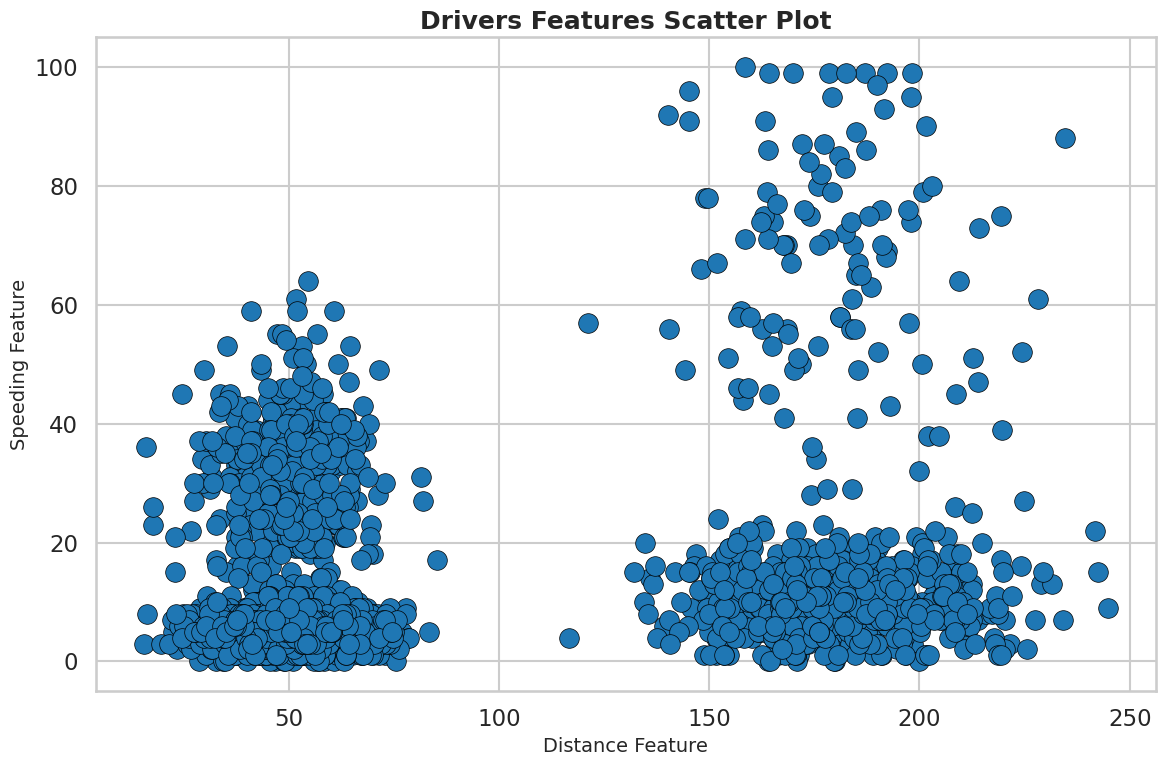

In [35]:
plot_drivers_features(df)

In [58]:
def plot_clusters(df, labels, centers=None):
    """
    Draw scatter plot with clusters.

    Parameters
    ----------
    df : pandas.DataFrame
        Date with columns Distance_Feature, Speeding_Feature.
    labels : array-like
        Clusters predictions (np. model.labels_).
    centers : np.ndarray or None
        Optional clusters' center , shape (k, 2).
    """
    sns.set_theme(style="whitegrid", context="talk")

    fig, ax = plt.subplots(figsize=(12, 8))

    sns.scatterplot(
        data=df,
        x="Distance_Feature",
        y="Speeding_Feature",
        hue=labels,
        palette="tab10",
        s=200,
        edgecolor="black",
        linewidth=0.5,
        ax=ax,
        legend="full"
    )

    if centers is not None:
        ax.scatter(
            centers[:, 0],
            centers[:, 1],
            s=400,
            c="black",
            marker="X",
            edgecolor="white",
            linewidth=1.2,
            label="Centroids"
        )

    ax.set_title("Clustered Drivers Features", fontsize=18, fontweight="bold")
    ax.set_xlabel("Distance Feature", fontsize=14)
    ax.set_ylabel("Speeding Feature", fontsize=14)

    plt.legend()
    plt.tight_layout()
    plt.show()

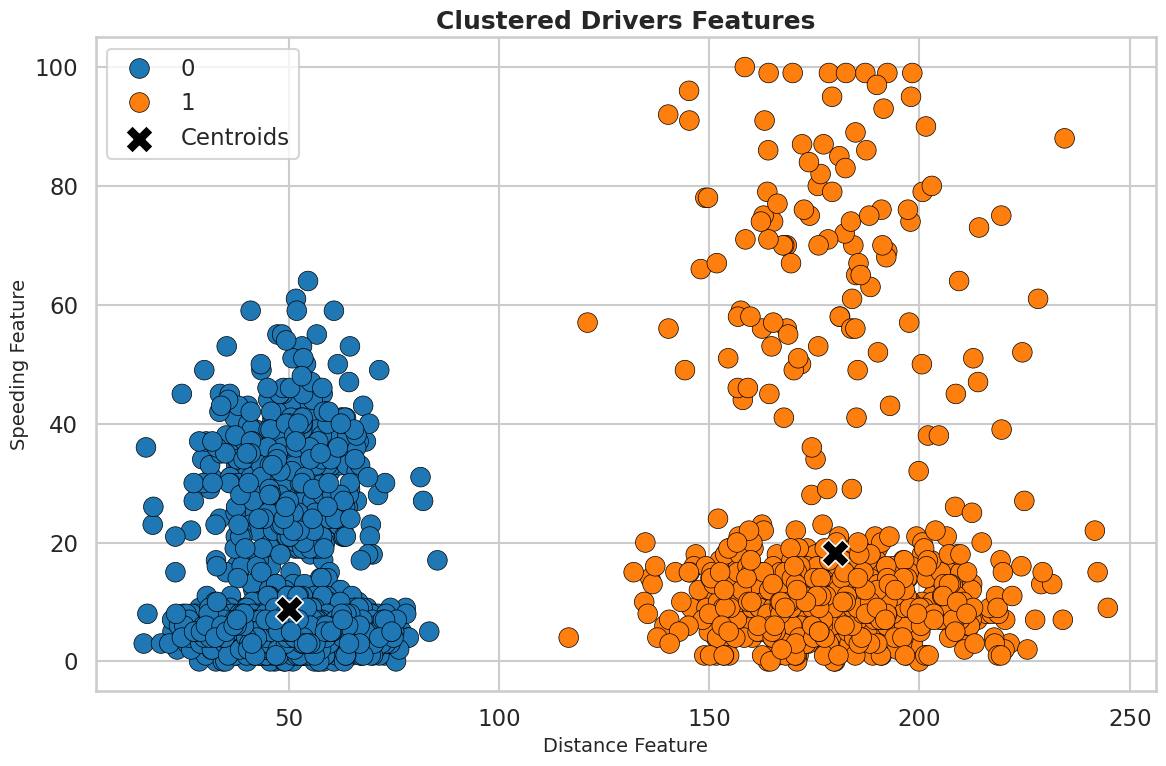

In [37]:
model = KMeans(n_clusters=2, random_state=42)
model.fit(features)

labels = model.labels_
centers = model.cluster_centers_

plot_clusters(features, labels, centers)

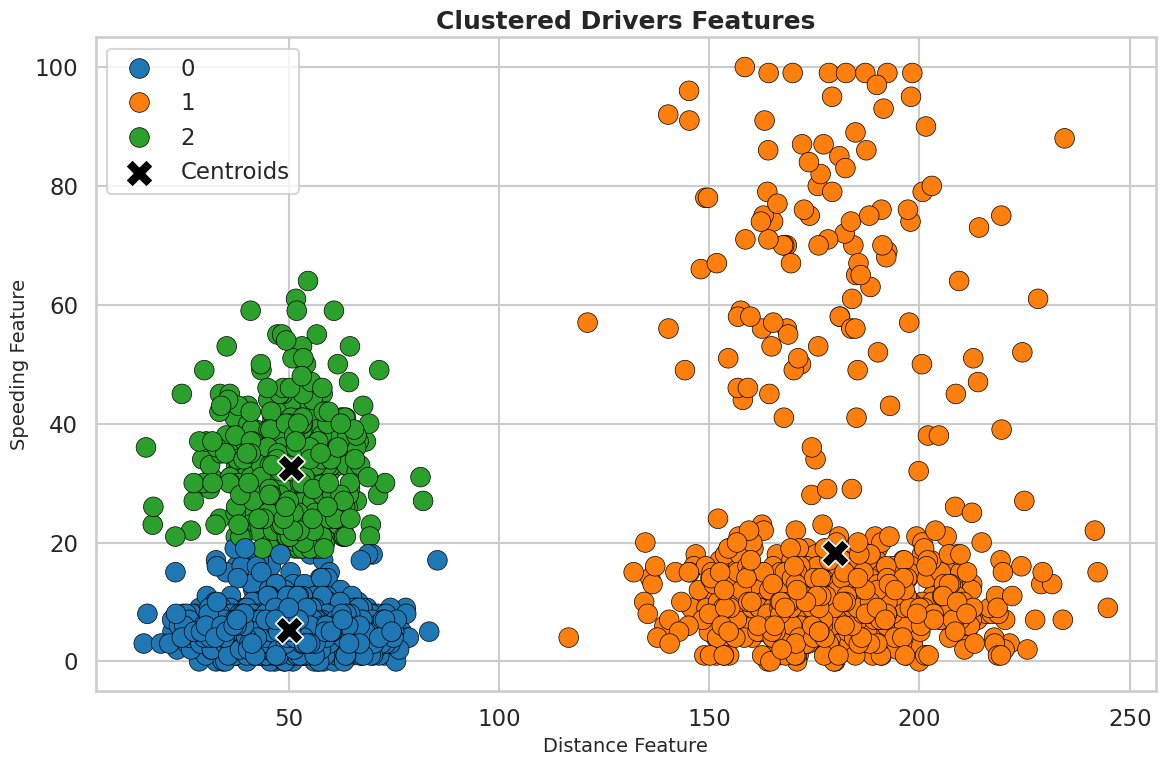

In [38]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(features)

labels = model.labels_
centers = model.cluster_centers_

plot_clusters(features, labels, centers)

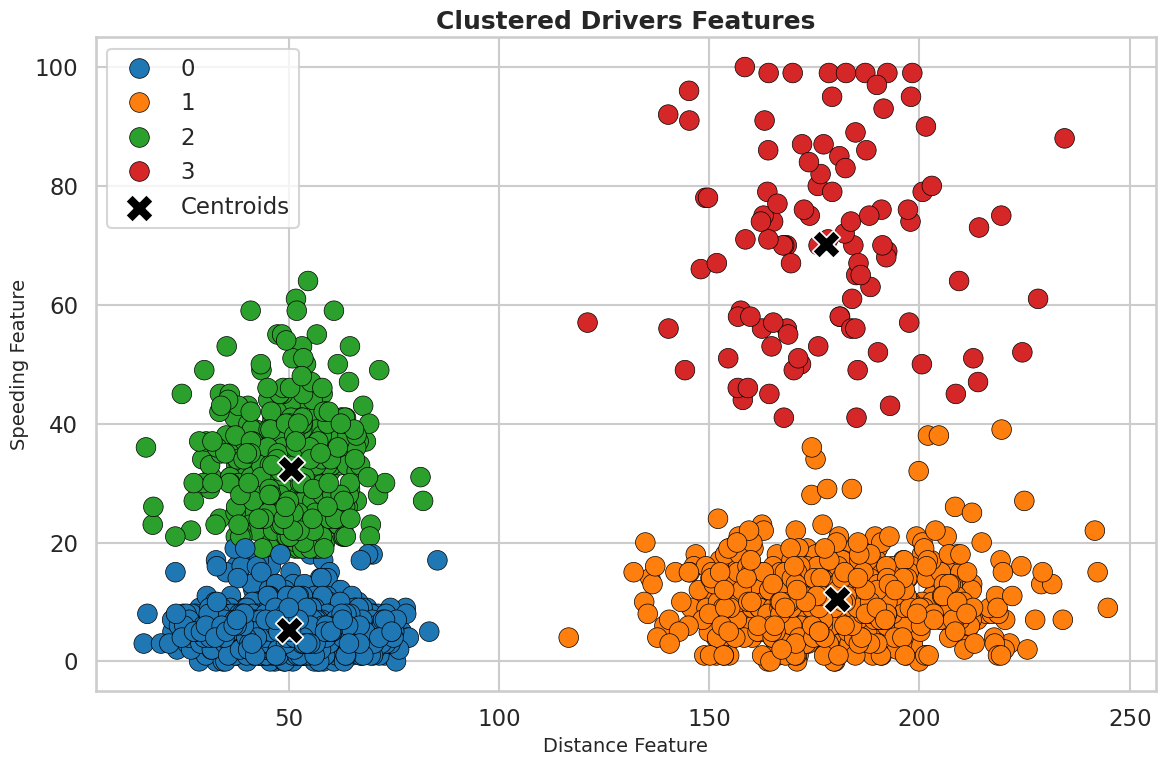

In [39]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(features)

labels = model.labels_
centers = model.cluster_centers_

plot_clusters(features, labels, centers)

In [40]:
parameters = {'eps': [0.9, 1.0, 5.0, 10.0, 12.0, 14.0, 20.0],
              'min_samples': [5, 7, 10, 12]}

In [41]:
parameter_grid = ParameterGrid(parameters)
list(parameter_grid)

[{'eps': 0.9, 'min_samples': 5},
 {'eps': 0.9, 'min_samples': 7},
 {'eps': 0.9, 'min_samples': 10},
 {'eps': 0.9, 'min_samples': 12},
 {'eps': 1.0, 'min_samples': 5},
 {'eps': 1.0, 'min_samples': 7},
 {'eps': 1.0, 'min_samples': 10},
 {'eps': 1.0, 'min_samples': 12},
 {'eps': 5.0, 'min_samples': 5},
 {'eps': 5.0, 'min_samples': 7},
 {'eps': 5.0, 'min_samples': 10},
 {'eps': 5.0, 'min_samples': 12},
 {'eps': 10.0, 'min_samples': 5},
 {'eps': 10.0, 'min_samples': 7},
 {'eps': 10.0, 'min_samples': 10},
 {'eps': 10.0, 'min_samples': 12},
 {'eps': 12.0, 'min_samples': 5},
 {'eps': 12.0, 'min_samples': 7},
 {'eps': 12.0, 'min_samples': 10},
 {'eps': 12.0, 'min_samples': 12},
 {'eps': 14.0, 'min_samples': 5},
 {'eps': 14.0, 'min_samples': 7},
 {'eps': 14.0, 'min_samples': 10},
 {'eps': 14.0, 'min_samples': 12},
 {'eps': 20.0, 'min_samples': 5},
 {'eps': 20.0, 'min_samples': 7},
 {'eps': 20.0, 'min_samples': 10},
 {'eps': 20.0, 'min_samples': 12}]

In [42]:
grid_search_silhouette(DBSCAN(), parameter_grid, features.values)

[GridSearch] params={'eps': 0.9, 'min_samples': 5} → silhouette=-0.6057
[GridSearch] params={'eps': 0.9, 'min_samples': 7} → silhouette=-0.4265
[GridSearch] params={'eps': 0.9, 'min_samples': 10} → silhouette=-0.3925
[GridSearch] params={'eps': 0.9, 'min_samples': 12} → silhouette=-0.4287
[GridSearch] params={'eps': 1.0, 'min_samples': 5} → silhouette=-0.6156
[GridSearch] params={'eps': 1.0, 'min_samples': 7} → silhouette=-0.4164
[GridSearch] params={'eps': 1.0, 'min_samples': 10} → silhouette=-0.3838
[GridSearch] params={'eps': 1.0, 'min_samples': 12} → silhouette=-0.3865
[GridSearch] params={'eps': 5.0, 'min_samples': 5} → silhouette=0.3101
[GridSearch] params={'eps': 5.0, 'min_samples': 7} → silhouette=0.7820
[GridSearch] params={'eps': 5.0, 'min_samples': 10} → silhouette=0.7974
[GridSearch] params={'eps': 5.0, 'min_samples': 12} → silhouette=0.7914
[GridSearch] params={'eps': 10.0, 'min_samples': 5} → silhouette=0.7598
[GridSearch] params={'eps': 10.0, 'min_samples': 7} → silhouet

({'eps': 20.0, 'min_samples': 5}, 0.8490223286225532)

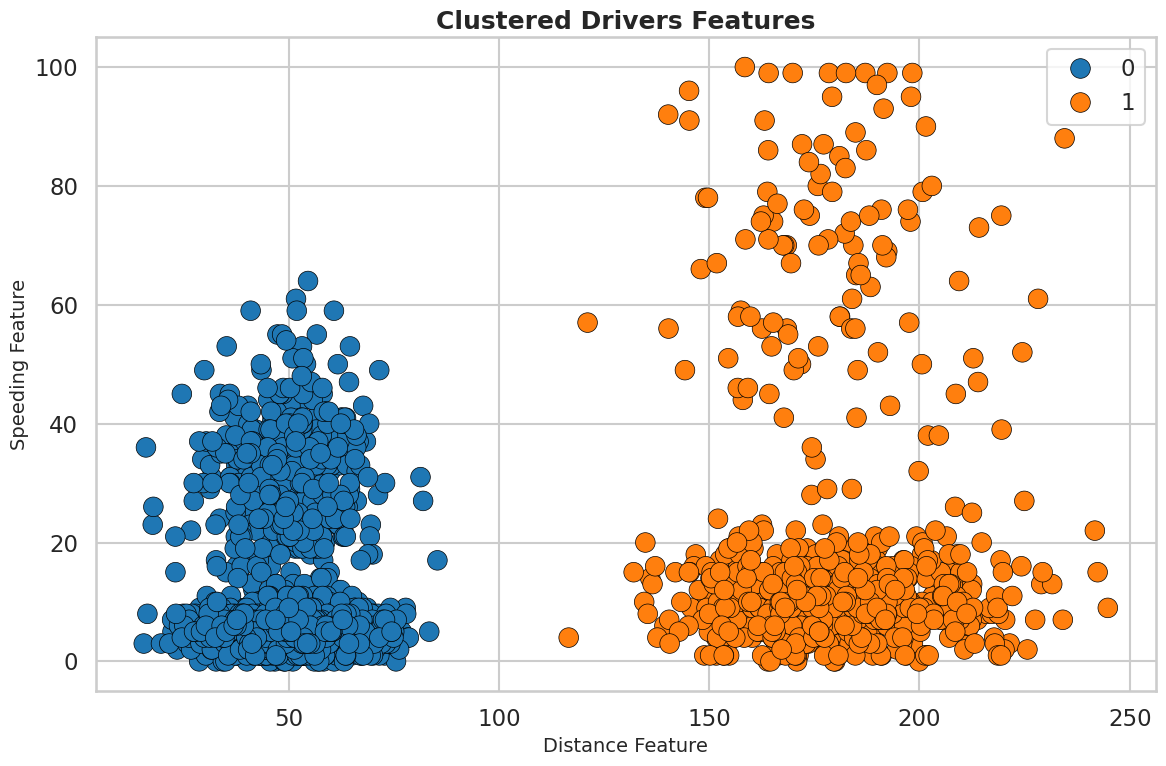

In [46]:
model = DBSCAN(eps=20.0, min_samples=5)
model.fit(features)

labels = model.labels_

plot_clusters(features, labels)

In [47]:
len(model.labels_)

4000

In [49]:
x = {-1, 2, 3}
print(x)
x.discard(-1)
print(x)

{2, 3, -1}
{2, 3}


In [51]:
def count_clusters(labels):
    unique = set(labels)
    unique.discard(-1)

    return len(unique)

In [52]:
count_clusters(model.labels_)

2

In [50]:
from typing import Iterable, Tuple


def cluster_stats(labels: Iterable[int]) -> Tuple[int, int]:
    """
    Compute basic clustering statistics:
    - number of clusters (excluding noise label -1)
    - number of noise points (label == -1)

    Parameters
    ----------
    labels : Iterable[int]
        Array of cluster labels, typically model.labels_.

    Returns
    -------
    n_clusters : int
        Number of clusters excluding noise.
    n_noise : int
        Number of points labeled as noise (-1).
    """
    labels = list(labels)

    n_clusters = len(set(labels) - {-1})
    n_noise = labels.count(-1)

    return n_clusters, n_noise

In [53]:
cluster_stats(model.labels_)

(2, 0)

In [54]:
bandwidth = estimate_bandwidth(features)
bandwidth

np.float64(33.960524729584314)

In [55]:
model = MeanShift(bandwidth=bandwidth, n_jobs=-1).fit(features)
silhouette_score(features, model.labels_)

0.8231396834167266

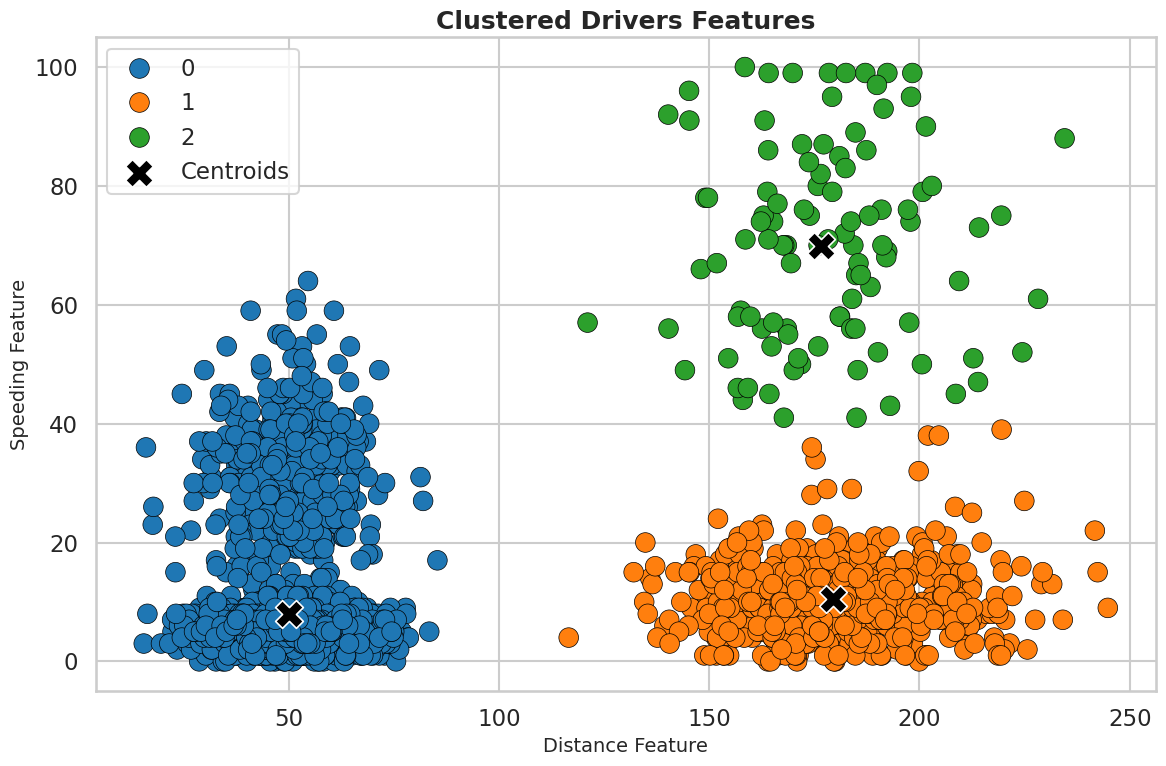

In [56]:
labels = model.labels_
centers = model.cluster_centers_

plot_clusters(features, labels, centers)

Estimated bandwidth: 33.9605
Silhouette score: 0.8231


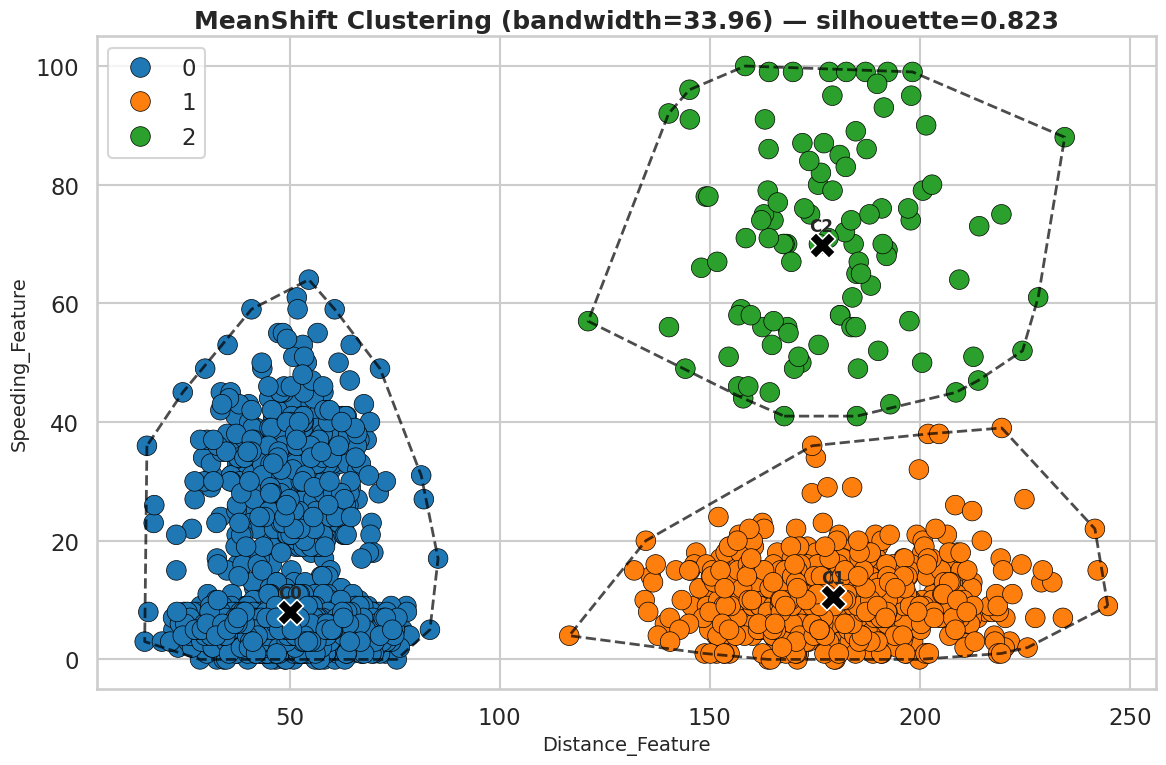

In [59]:
def plot_meanshift_with_hulls(df):
    sns.set_theme(style="whitegrid", context="talk")

    X = df[["Distance_Feature", "Speeding_Feature"]].values
    bw = estimate_bandwidth(X)
    print(f"Estimated bandwidth: {bw:.4f}")

    model = MeanShift(bandwidth=bw)
    model.fit(X)

    labels = model.labels_
    centers = model.cluster_centers_

    score = silhouette_score(X, labels)
    print(f"Silhouette score: {score:.4f}")

    fig, ax = plt.subplots(figsize=(12, 8))

    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=labels,
        palette="tab10",
        s=200,
        edgecolor="black",
        linewidth=0.5,
        ax=ax,
        legend="full"
    )

    unique_labels = np.unique(labels)
    for lab in unique_labels:
        pts = X[labels == lab]

        if len(pts) < 3:
            continue

        hull = ConvexHull(pts)
        poly = pts[hull.vertices]
        poly = np.vstack([poly, poly[0]])

        ax.plot(poly[:, 0], poly[:, 1], "--", color="black", linewidth=2, alpha=0.7)

    ax.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="X",
        s=350,
        c="black",
        edgecolor="white",
        linewidth=1.2,
        label="Cluster centers"
    )

    for i, (cx, cy) in enumerate(centers):
        ax.annotate(
            f"C{i}",
            (cx, cy),
            xytext=(0, 10),
            textcoords="offset points",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

    ax.set_title(
        f"MeanShift Clustering (bandwidth={bw:.2f}) — silhouette={score:.3f}",
        fontsize=18,
        fontweight="bold"
    )
    ax.set_xlabel("Distance_Feature", fontsize=14)
    ax.set_ylabel("Speeding_Feature", fontsize=14)
    plt.tight_layout()
    plt.show()


plot_meanshift_with_hulls(features)